# Exploratory Data Analysis

This notebook will perform exploratory data analysis (EDA) of the training and test data. 

This will cover:
- Table summaries and views
- Null counts
- Summary statistics and distributional plots for numeric features
- Comparison of features between training and test data
- Time series analysis of features and target
- Analysis of correlations between the features and the label
- Exploration of raw feature predictive power using basic RandomForestRegressor and linear regression models


In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_context('talk')
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [10]:
#untie local dependency
import os
cwd = os.getcwd().split('\\')
local_repo_path = '\\'.join(cwd[:-1])
raw_data_path = local_repo_path + r'\data\raw'
processed_data_path = local_repo_path + '\data\processed'

Setup...

In [11]:
train = pd.read_csv(processed_data_path + r'\train_dataset.csv', index_col = 0)
test = pd.read_csv(raw_data_path + r'\dengue_features_test.csv', index_col = None)
combined = pd.read_csv(processed_data_path + r'\combined_train_test_dataset.csv', index_col = 0)

# Data view

In [12]:
#cm = sns.light_palette("green", as_cmap=True)
#train.style.background_gradient(cmap=cm)

In [13]:
#cm = sns.light_palette("orange", as_cmap=True)
#test.style.background_gradient(cmap = cm)

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1456 entries, 0 to 1455
Data columns (total 25 columns):
city                                     1456 non-null object
year                                     1456 non-null int64
weekofyear                               1456 non-null int64
week_start_date                          1456 non-null object
ndvi_ne                                  1262 non-null float64
ndvi_nw                                  1404 non-null float64
ndvi_se                                  1434 non-null float64
ndvi_sw                                  1434 non-null float64
precipitation_amt_mm                     1443 non-null float64
reanalysis_air_temp_k                    1446 non-null float64
reanalysis_avg_temp_k                    1446 non-null float64
reanalysis_dew_point_temp_k              1446 non-null float64
reanalysis_max_air_temp_k                1446 non-null float64
reanalysis_min_air_temp_k                1446 non-null float64
reanalysis_precip

**Features are a mostly numeric. City and year/week of year can be considered as categorical with week_start_date a datetime. Output is a numeric variable (integer number of total disease cases)**

# Null Counts

In [15]:
null_counts = pd.DataFrame([(len(train) - train.count())/len(train), (len(test) - test.count())/len(test)]).transpose().reset_index()
null_counts.rename({'index': 'Column',0:'Train', 1:'Test'}, axis = 1, inplace = True)
null_counts = pd.melt(null_counts,id_vars = ['Column'], value_vars=['Train', 'Test']).rename({'variable':'Dataset'}, axis = 1)

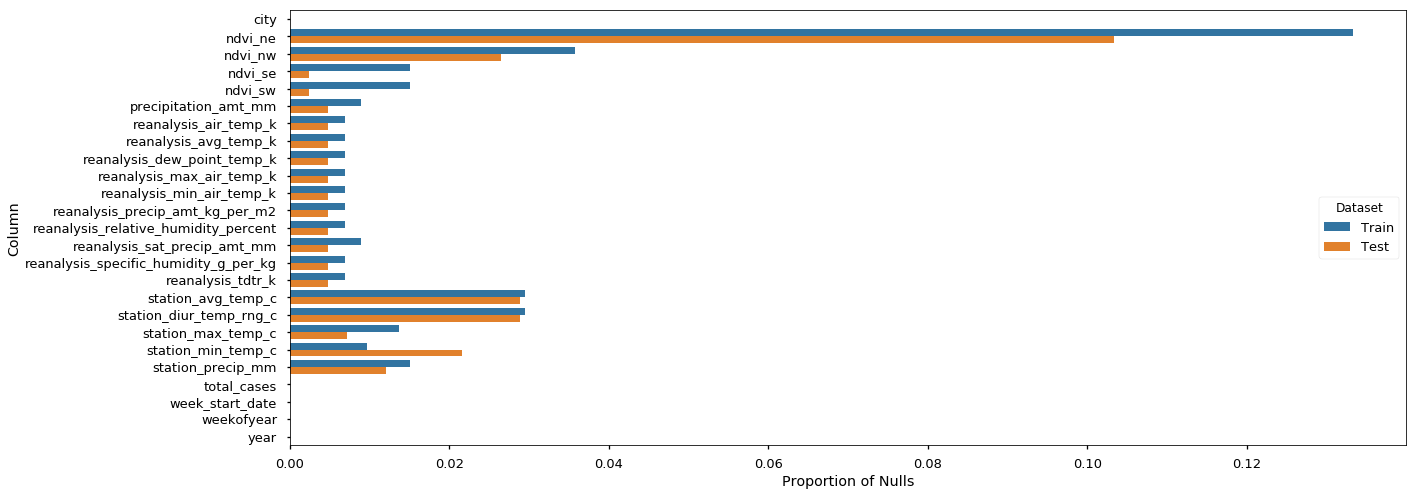

In [16]:
fig, ax = plt.subplots(figsize = (20,8))
sns.barplot(x = 'value', y = 'Column', hue = 'Dataset', data = null_counts, orient = 'h', ax = ax)
plt.xlabel('Proportion of Nulls');

**Null counts are similarly distributed across test and training classes. The only feature with a significant number of nulls is ndvi_ne. The rate justifies experimenting with null imputation in the feature engineering steps**

In [17]:
numeric_cols = combined.select_dtypes(include=[np.number]).drop(['year', 'weekofyear'], axis = 1).columns

# Between city feature comparison (combined test and training data)

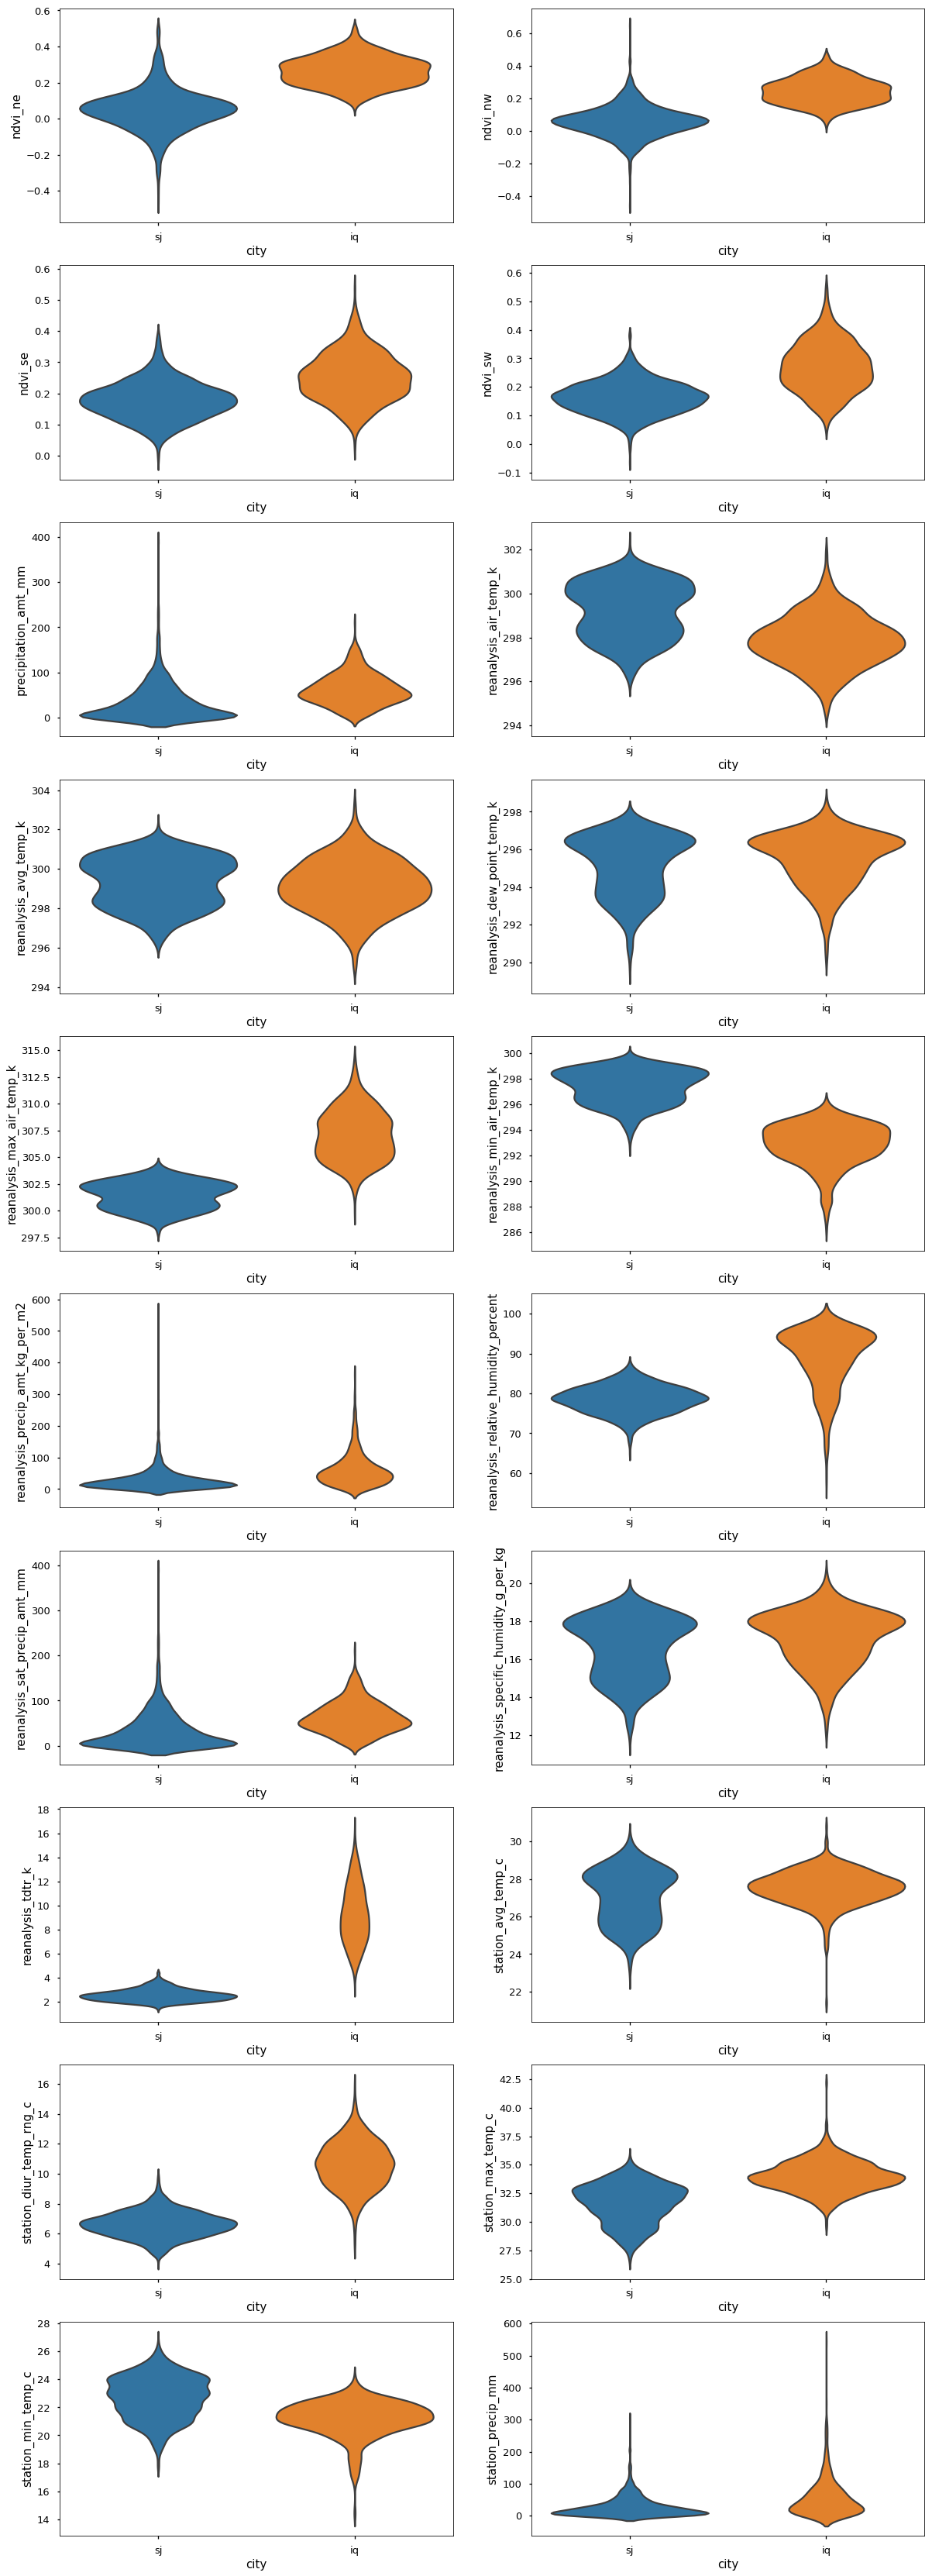

In [18]:
fix, ax = plt.subplots(nrows = 10, ncols = 2, figsize = (20,60))
for i, j in enumerate(numeric_cols):
    sns.violinplot(x = 'city', y = j, data = combined, inner = None, ax = ax[int(np.floor(i/2)),np.mod(i,2)])
    ax[int(np.floor(i/2)),np.mod(i,2)].yaxis.label.set_size(15)
    ax[int(np.floor(i/2)),np.mod(i,2)].xaxis.label.set_size(15)

**There are 20 numerical measurement features found in the data, each representing a weather measurement in city 'sj' or 'iq' in a certain week. There are some differences to be found between the cities. For example, reanalysis_max_air_temp_k appears to not have the same distribution of measurements. It would take some contextual knowledge of the measurements to confirm that however, i.e. is the average measure of 307.5 vs. 301 a significant climate difference indication?**

# Train/test measurement times

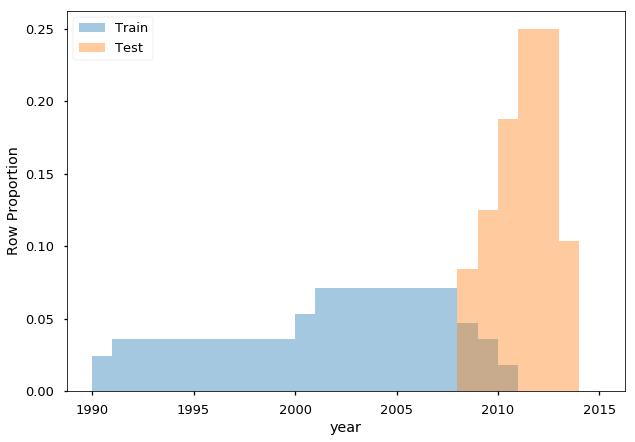

In [19]:
fig, ax = plt.subplots(figsize = (10,7))
sns.distplot(combined['year'][combined['dataset'] == 'train'], kde = False, label = 'Train', bins = np.arange(1990, 2016), norm_hist = True)
sns.distplot(combined['year'][combined['dataset'] == 'test'], kde = False, label = 'Test', bins = np.arange(1990,2016), norm_hist = True)
plt.legend();
plt.ylabel('Row Proportion');

** Measurements are taken during different periods of time between the test and training datasets. The range of time the training data samples from spans over 20 years between 1990 and 2011, whereast test data measurements are 2008-2014. **

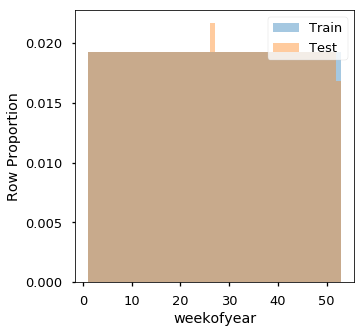

In [20]:
fig, ax = plt.subplots(figsize = (5,5))
sns.distplot(combined['weekofyear'][combined['dataset'] == 'train'], kde = False, label = 'Train', bins = np.arange(1, 54), norm_hist = True)
sns.distplot(combined['weekofyear'][combined['dataset'] == 'test'], kde = False, label = 'Test', bins = np.arange(1,54), norm_hist = True)
plt.legend();
plt.ylabel('Row Proportion');

# Comparison of train and test features for each city

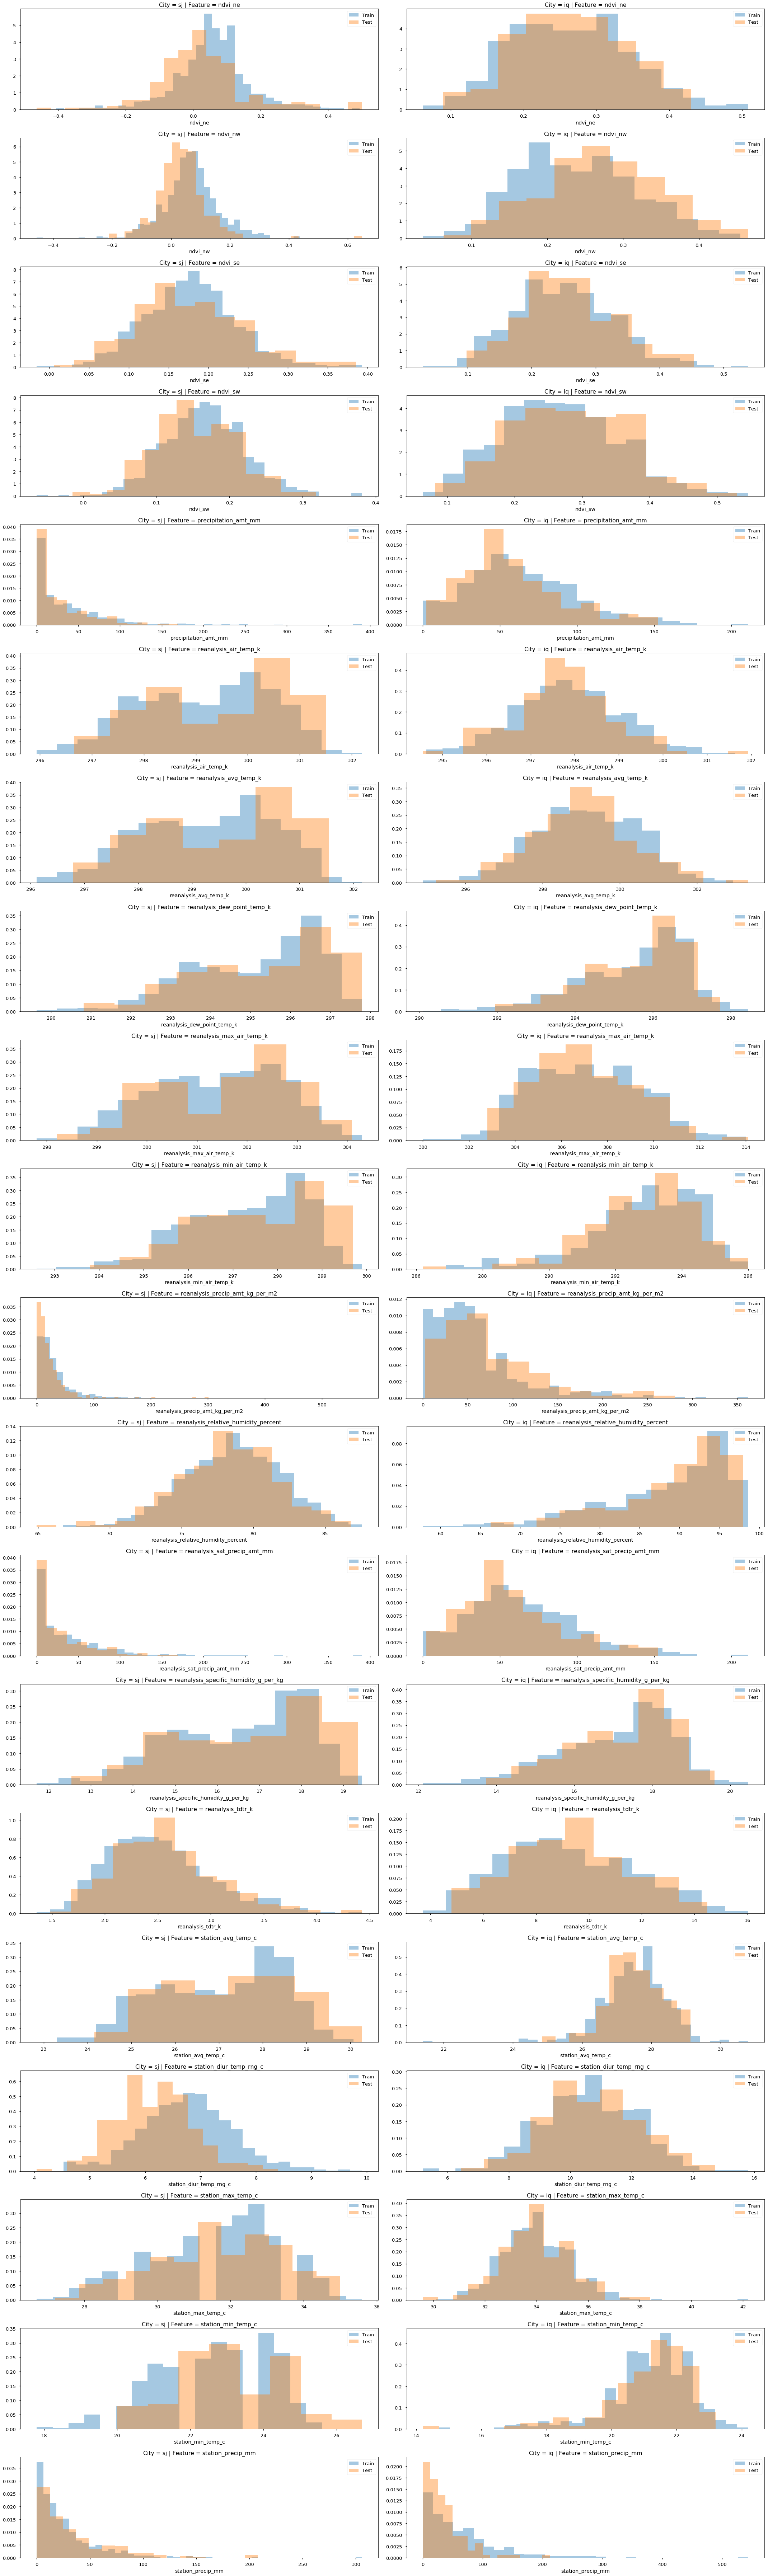

In [21]:
fix, ax = plt.subplots(nrows = 20, ncols = 2, figsize = (30,100))
cities = ['sj', 'iq']
for i, col in enumerate(numeric_cols):
    for j, city in enumerate(cities):
        axes = ax[i,j]
        sns.distplot(combined[col][(combined['dataset'] == 'train') & (combined['city'] == city)].dropna(), kde = False, label = 'Train', norm_hist = True, ax = axes)
        sns.distplot(combined[col][(combined['dataset'] == 'test') & (combined['city'] == city)].dropna(), kde = False, label = 'Test', norm_hist = True, ax = axes)
        axes.legend(loc = 'upper right');
        axes.set_title('City = '+  city + ' | Feature = ' + col)
        plt.tight_layout()

***To the eye there aren't any features that show significant difference between the training and test set. The ones that appear most different are *nvdi_nw* in iq and *station_diur_temp_rng_c* in sj.***

# Features for each city, over time

Recordings are taken over different time periods for each city

In [22]:
iq_start, iq_end = train[train['city'] == 'iq']['week_start_date'].min(), train[train['city'] == 'iq']['week_start_date'].max()
sj_start, sj_end = train[train['city'] == 'sj']['week_start_date'].min(), train[train['city'] == 'sj']['week_start_date'].max()
print('iq training date range: ', iq_start + ' to ' + iq_end)
print('sj training date range: ', sj_start + ' to ' + sj_end)

iq date range:  2000-07-01 to 2010-06-25
sj date range:  1990-04-30 to 2008-04-22


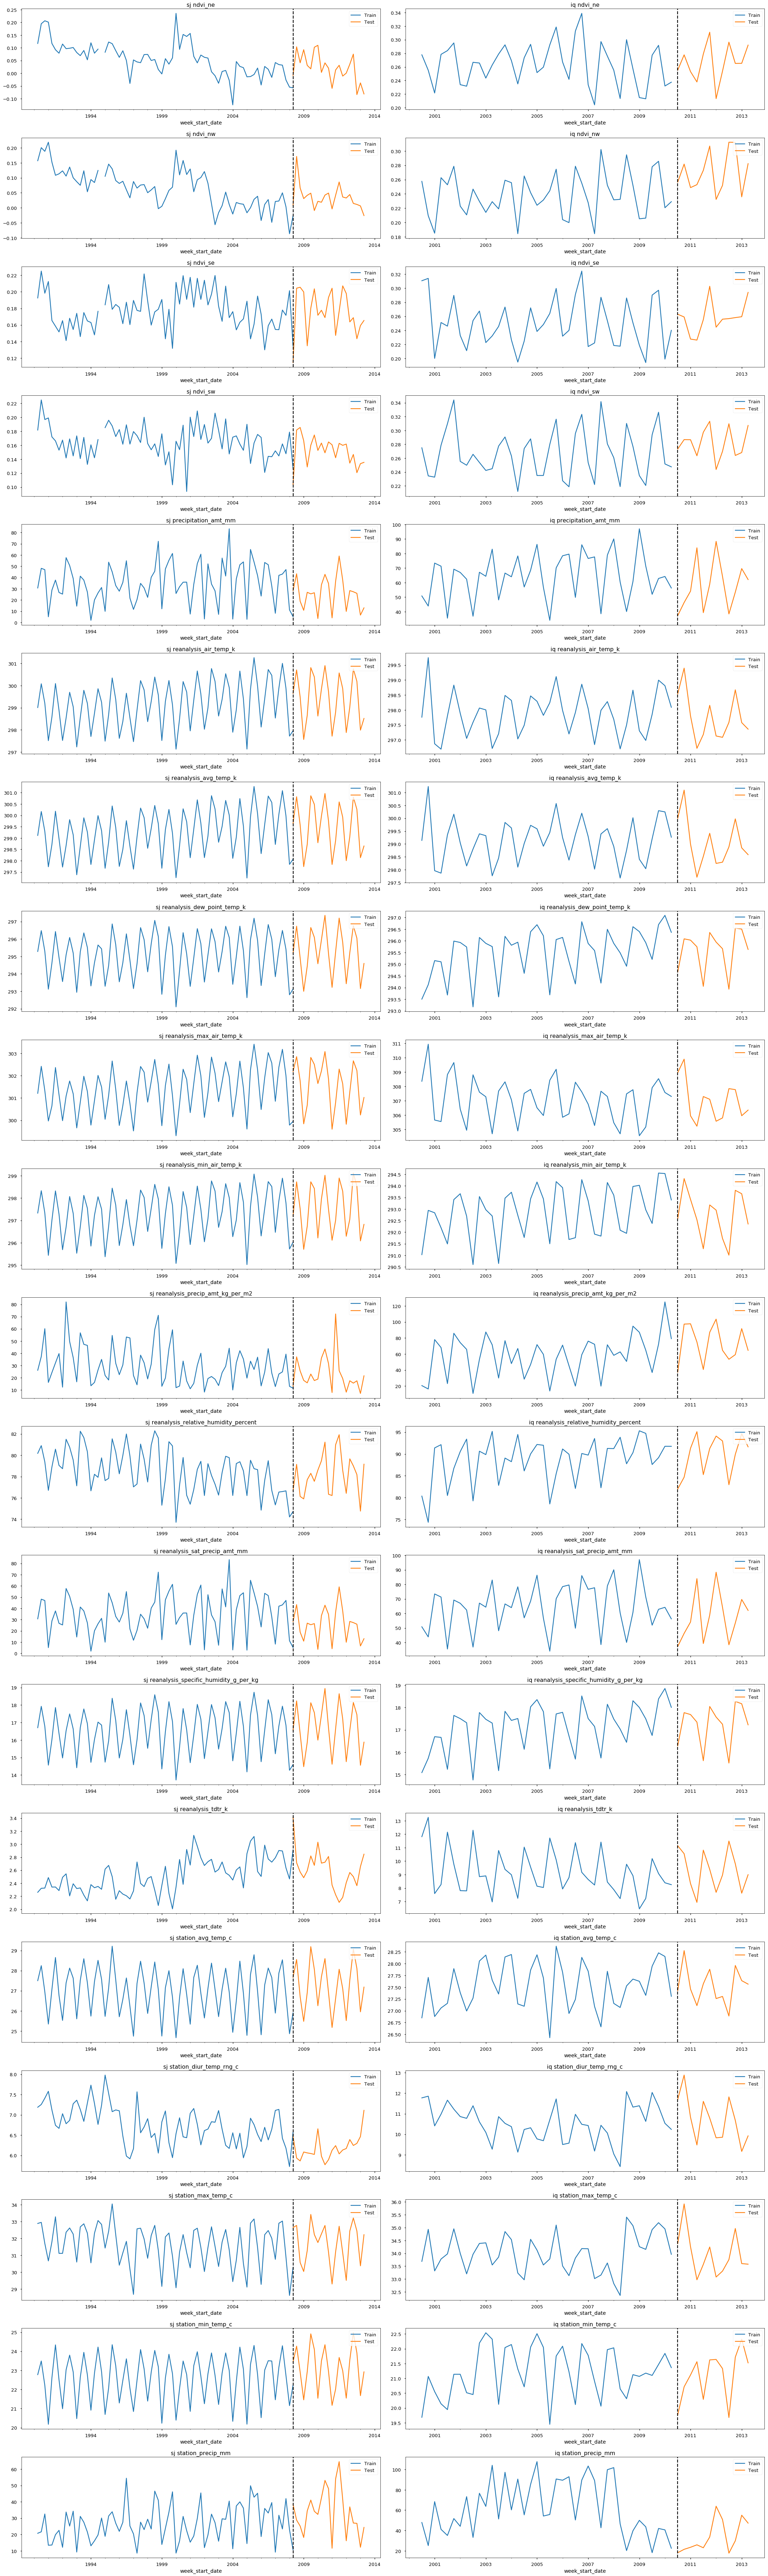

In [23]:
fig, ax = plt.subplots(nrows = 20, ncols = 2, figsize = (30,100))
cities = ['sj', 'iq']
for i, col in enumerate(numeric_cols):
    for j, city in enumerate(cities):
        axes = ax[i,j]
        train_test_split_date = np.where(city == 'iq', pd.Timestamp('2010-08-15'), pd.Timestamp('2008-06-30')).tolist()
        train[train['city'] == city][['week_start_date', col]].set_index(pd.DatetimeIndex(train[train['city'] == city]['week_start_date'])).groupby(pd.Grouper(freq='Q')).mean().plot(ax = axes)
        test[test['city'] == city][['week_start_date', col]].set_index(pd.DatetimeIndex(test[test['city'] == city]['week_start_date'])).groupby(pd.Grouper(freq='Q')).mean().plot(ax = axes)
        axes.axvline(train_test_split_date, color = 'black', linestyle = 'dashed')
        axes.set_title(city + ' ' + col)
        axes.legend(labels=['Train', 'Test'], loc = 'upper right')
        plt.tight_layout()

***Some features show a clear pattern of correlation (e.g. station_min_temp_c), and some, to the eye, have some upward or downward trend.***

NB: Between cities, the training and test data is separable over time. However sj's training measurements stop in late 2008 wheras iq's ones stop in mid 2010. 

# Training data feature correlation heatmap

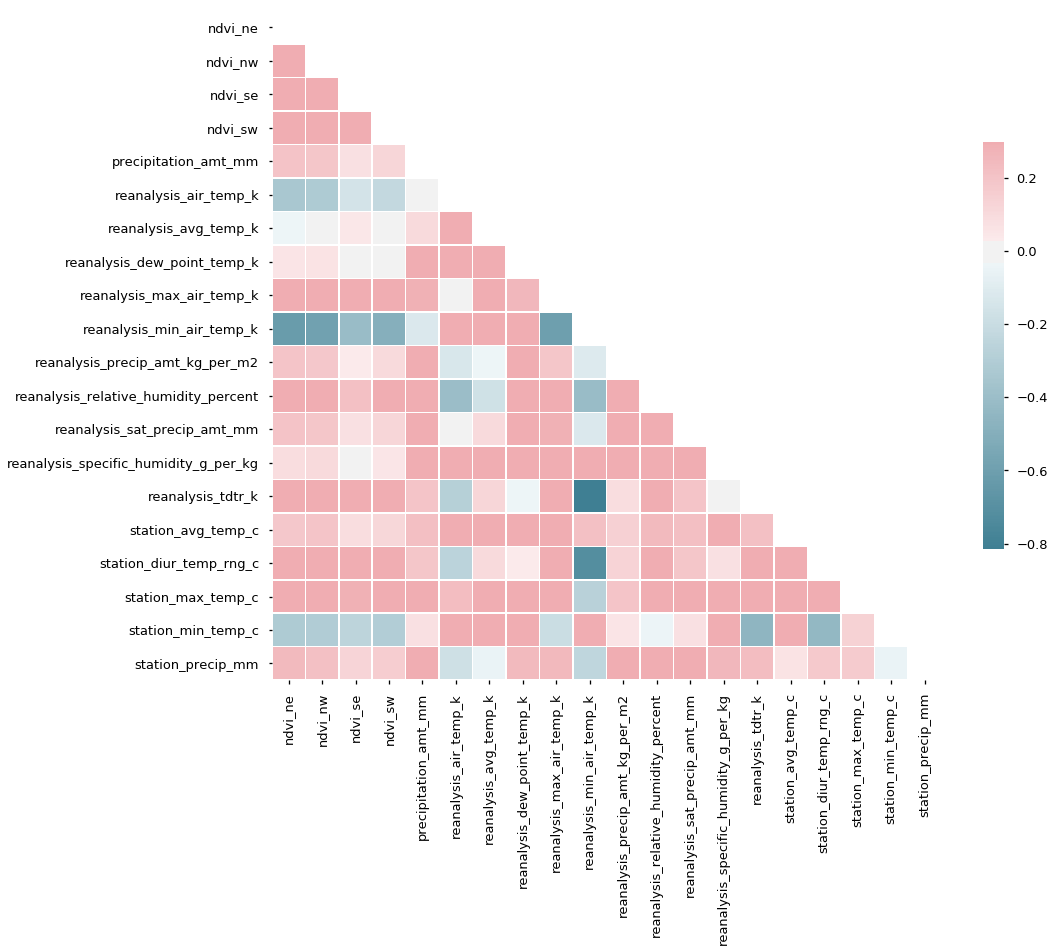

In [24]:
corr = train[numeric_cols].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize = (15,15))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(data = corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Test data feature correlations

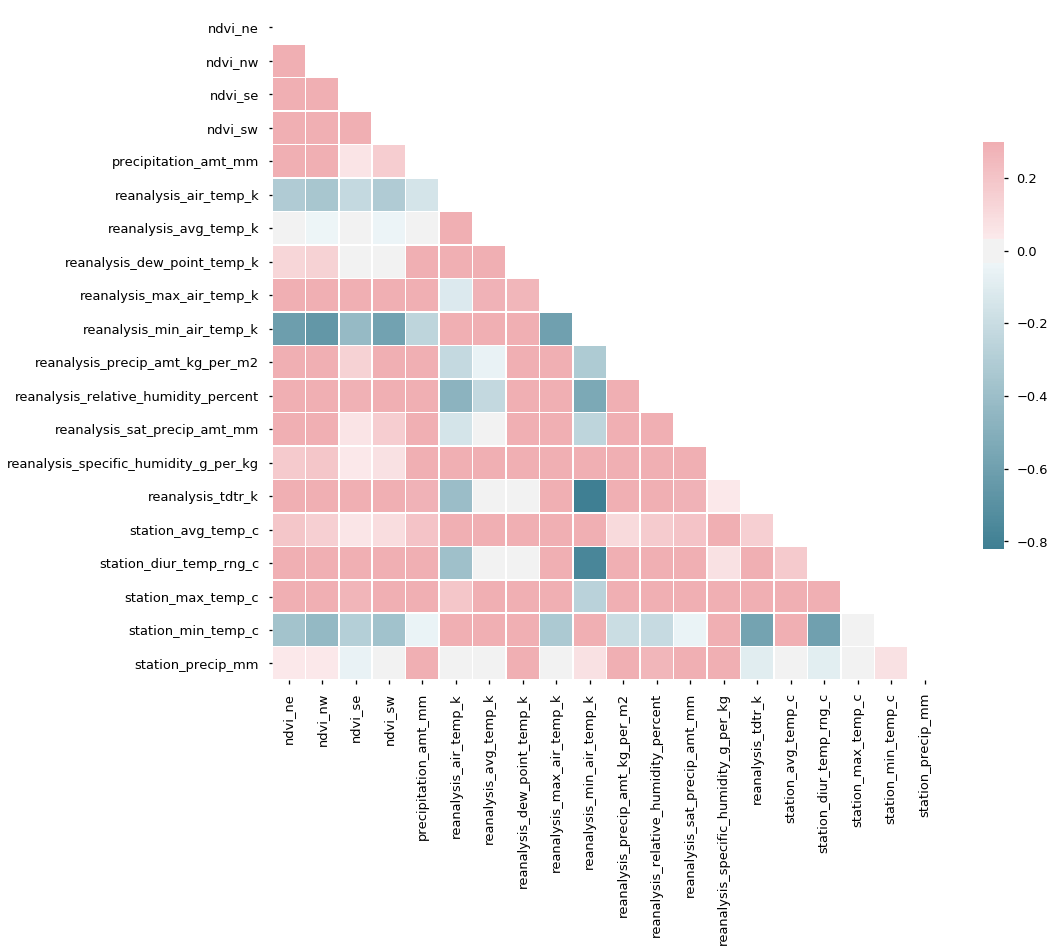

In [25]:
corr = test[numeric_cols].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize = (15,15))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(data = corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Target column analysis (train only)

## Total_cases (target) distribution 

## Heavy tailed; suggests 'outbreak' pattern

Text(0.5,0,'total_cases')

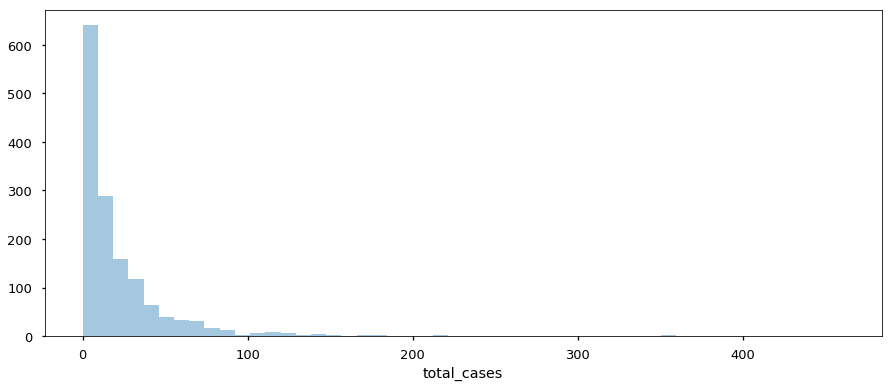

In [26]:
fig, ax = plt.subplots(figsize = (15,6))
ax = sns.distplot(train['total_cases'], kde = False)
ax.set_xlabel('total_cases')

## Consider logged distribution

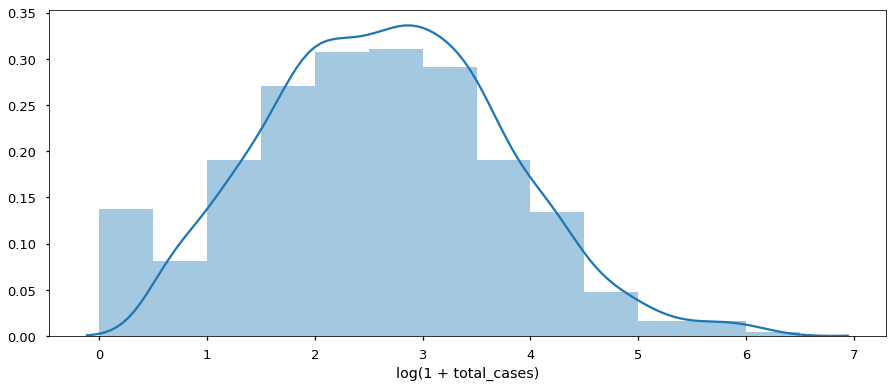

In [27]:
fig, ax = plt.subplots(figsize = (15,6))
ax = sns.distplot(np.log(1+train['total_cases']), kde = True, kde_kws={'clip': (0.0, 6.5)}, bins = np.arange(0, 7,0.5))
ax.set_xlabel('log(1 + total_cases)');

# Cities have different case distributions and recording periods

# Total cases distribution varies largely; typically a greater number of cases in sj

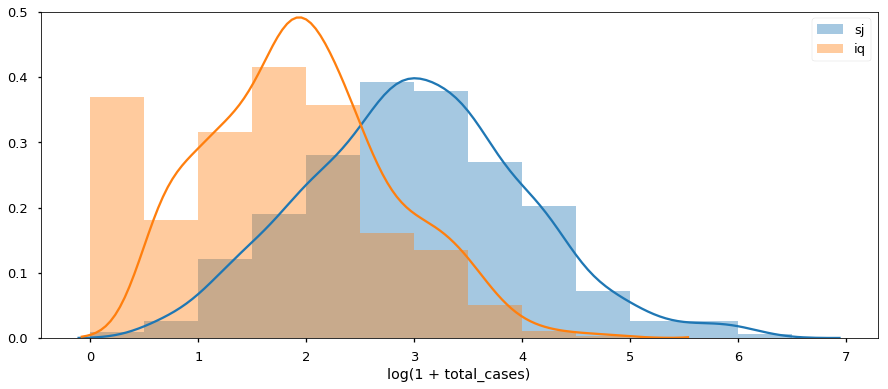

In [28]:
fig, ax = plt.subplots(figsize = (15,6))
sns.distplot(np.log(1+train[train['city'] == 'sj']['total_cases']), kde = True, kde_kws={'clip': (0.0, 6.5)}, bins = np.arange(0, 7,0.5), norm_hist = True, label = 'sj')
sns.distplot(np.log(1+train[train['city'] == 'iq']['total_cases']), kde = True, kde_kws={'clip': (0.0, 6.5)}, bins = np.arange(0, 7,0.5), norm_hist = True, label = 'iq')
ax.set_xlabel('log(1 + total_cases)');
ax.legend(loc = 'upper right')
ax.set_ylim(0,0.5);

In [29]:
train[train['city'] == 'iq']['total_cases'].describe()

count    520.000000
mean       7.565385
std       10.765478
min        0.000000
25%        1.000000
50%        5.000000
75%        9.000000
max      116.000000
Name: total_cases, dtype: float64

In [30]:
train[train['city'] == 'sj']['total_cases'].describe()

count    936.000000
mean      34.180556
std       51.381372
min        0.000000
25%        9.000000
50%       19.000000
75%       37.000000
max      461.000000
Name: total_cases, dtype: float64

# Quarterly total cases by city

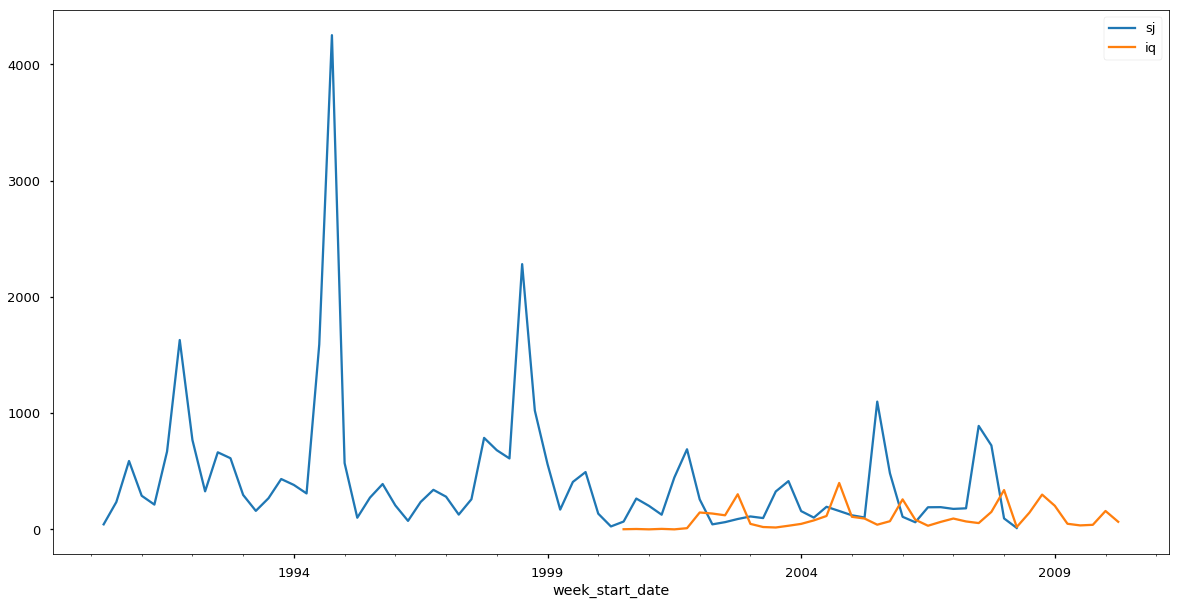

In [31]:
fig, ax = plt.subplots(figsize = (20,10))
train[train['city'] == 'sj'][['week_start_date', 'total_cases']].set_index(pd.DatetimeIndex(train[train['city'] == 'sj']['week_start_date'])).groupby(pd.Grouper(freq='Q')).sum().plot(ax = ax)
train[train['city'] == 'iq'][['week_start_date', 'total_cases']].set_index(pd.DatetimeIndex(train[train['city'] == 'iq']['week_start_date'])).groupby(pd.Grouper(freq='Q')).sum().plot(ax = ax)
ax.legend(labels = ['sj', 'iq'])

# And weekly..

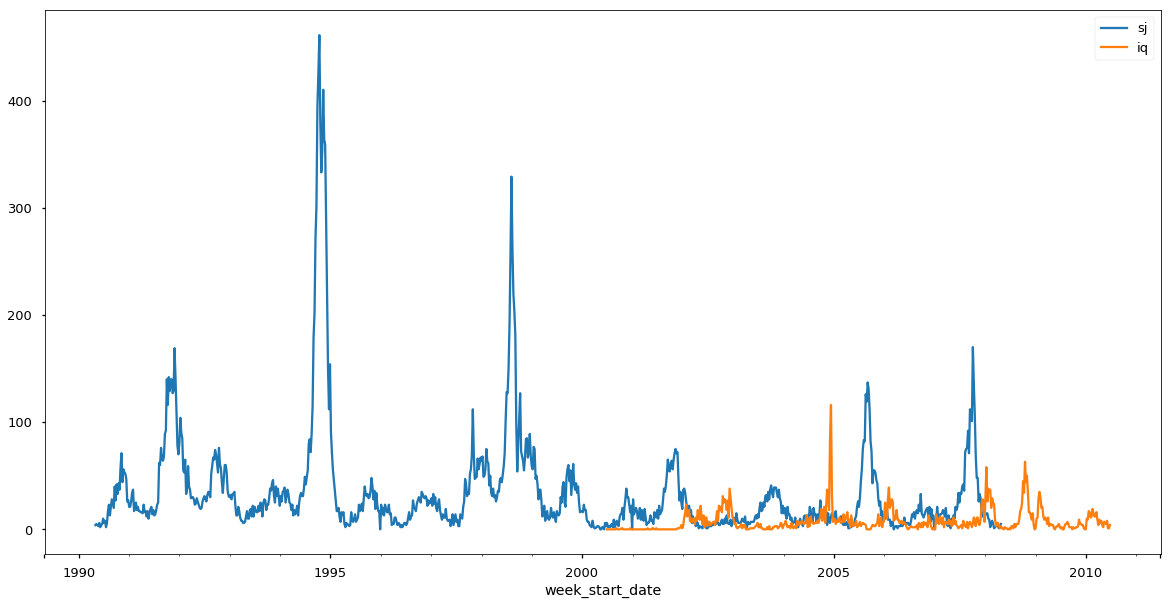

In [32]:
fig, ax = plt.subplots(figsize = (20,10))
train[train['city'] == 'sj'][['week_start_date', 'total_cases']].set_index(pd.DatetimeIndex(train[train['city'] == 'sj']['week_start_date'])).groupby(pd.Grouper(freq='W')).sum().plot(ax = ax)
train[train['city'] == 'iq'][['week_start_date', 'total_cases']].set_index(pd.DatetimeIndex(train[train['city'] == 'iq']['week_start_date'])).groupby(pd.Grouper(freq='W')).sum().plot(ax = ax)
ax.legend(labels = ['sj', 'iq'])

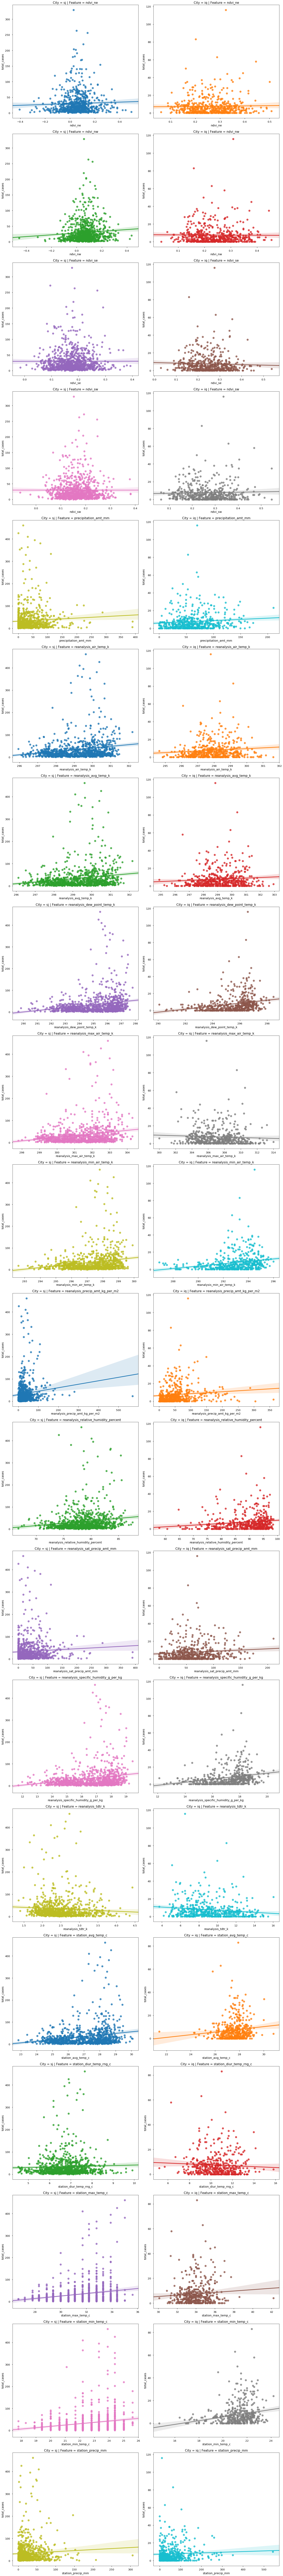

In [33]:
fix, ax = plt.subplots(nrows = 20, ncols = 2, figsize = (20,180))
cities = ['sj', 'iq']
for i, col in enumerate(numeric_cols):
    for j, city in enumerate(cities):
        axes = ax[i,j]
        sns.regplot(x=col, y="total_cases", data=train[train['city'] == city], ax = axes, scatter_kws={"s": 100});
        axes.set_title('City = '+  city + ' | Feature = ' + col)
        plt.tight_layout()

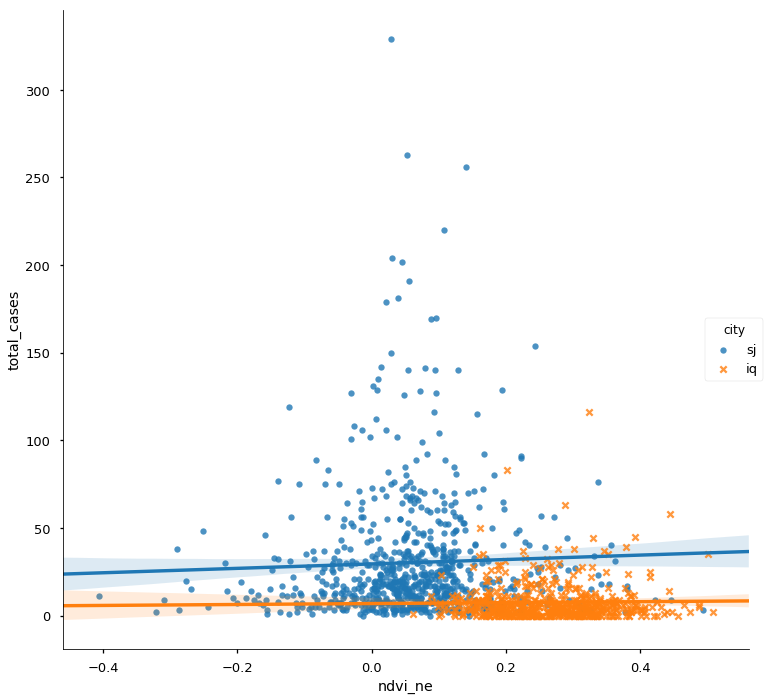

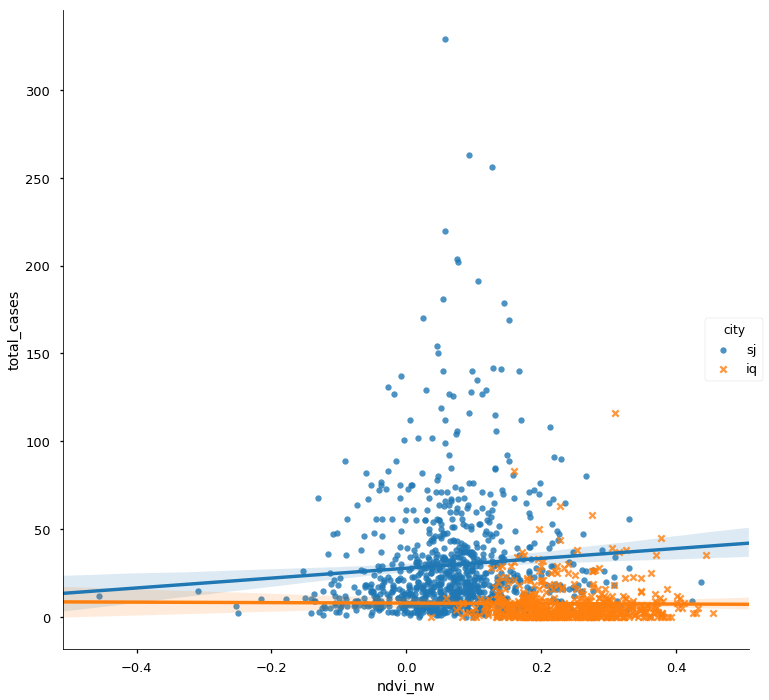

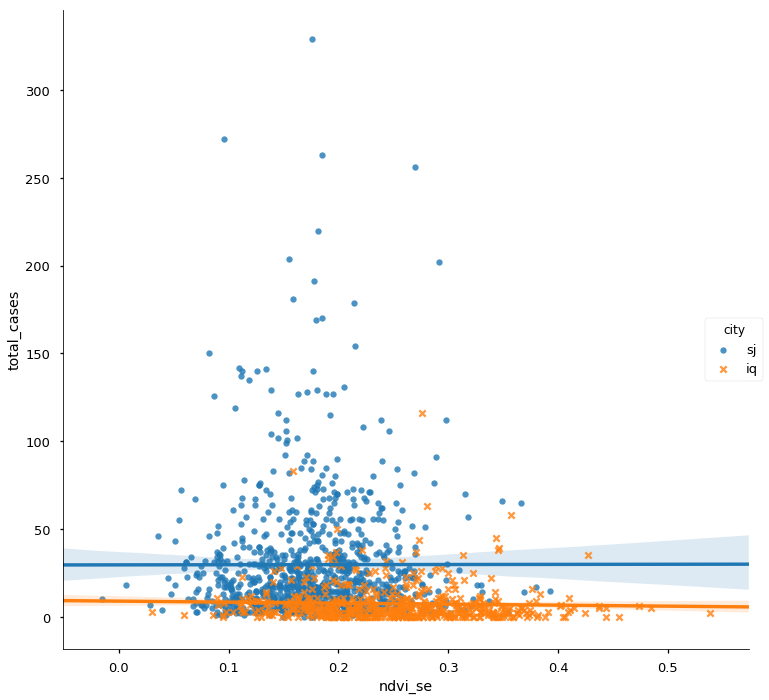

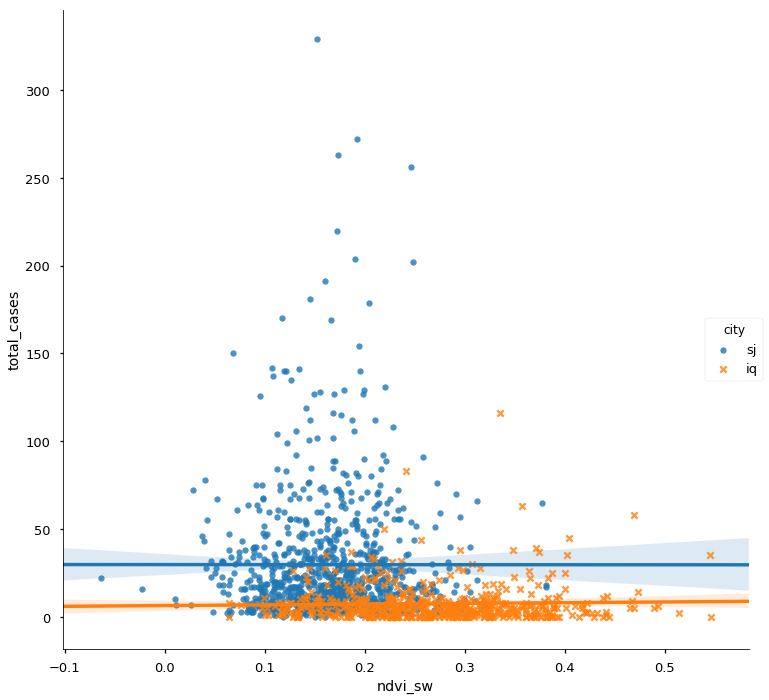

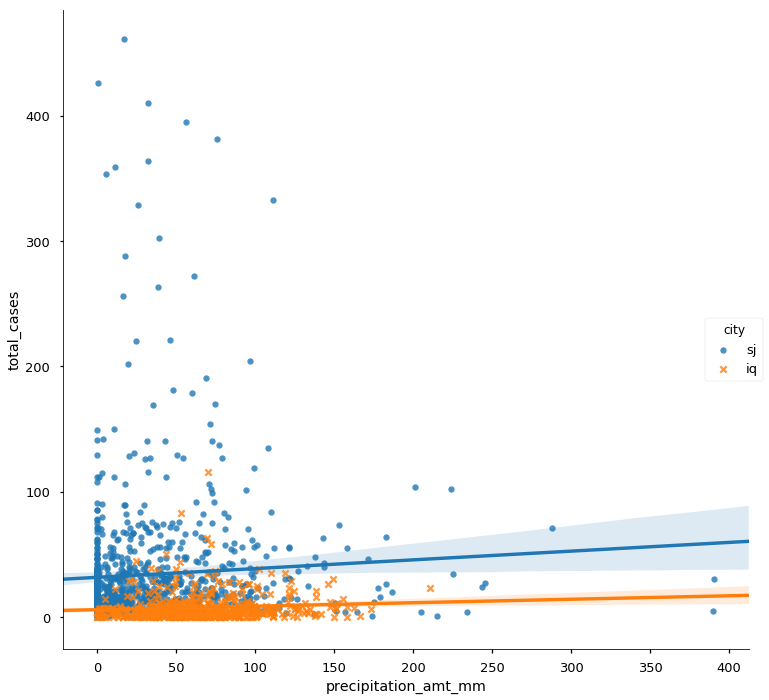

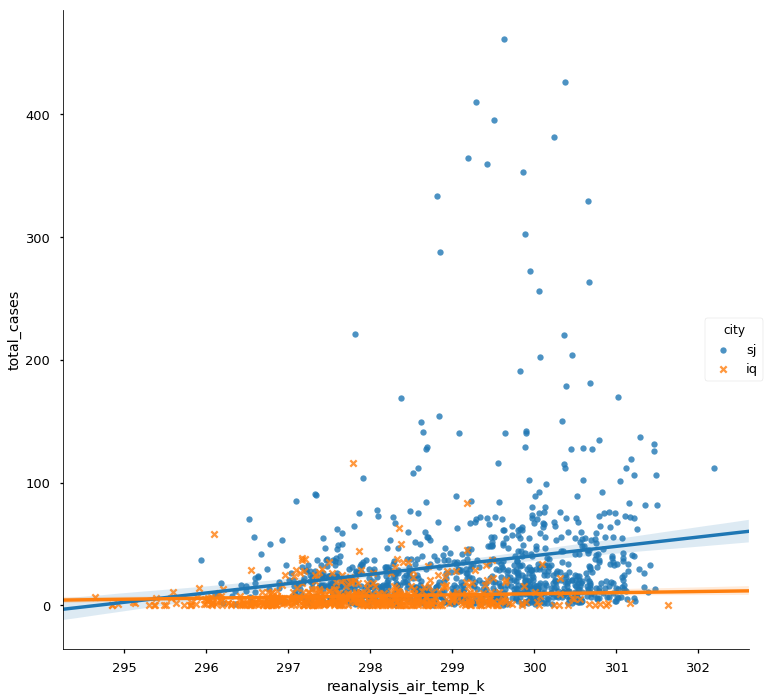

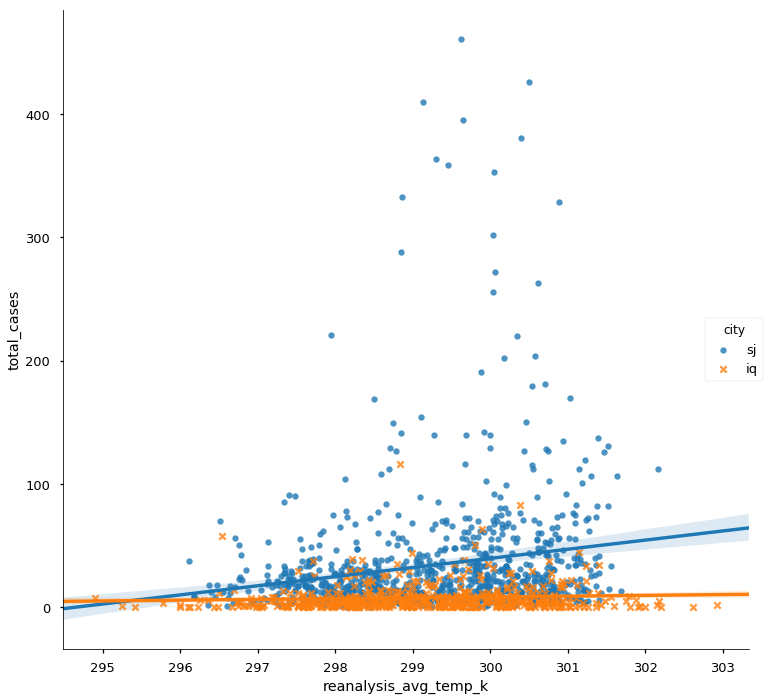

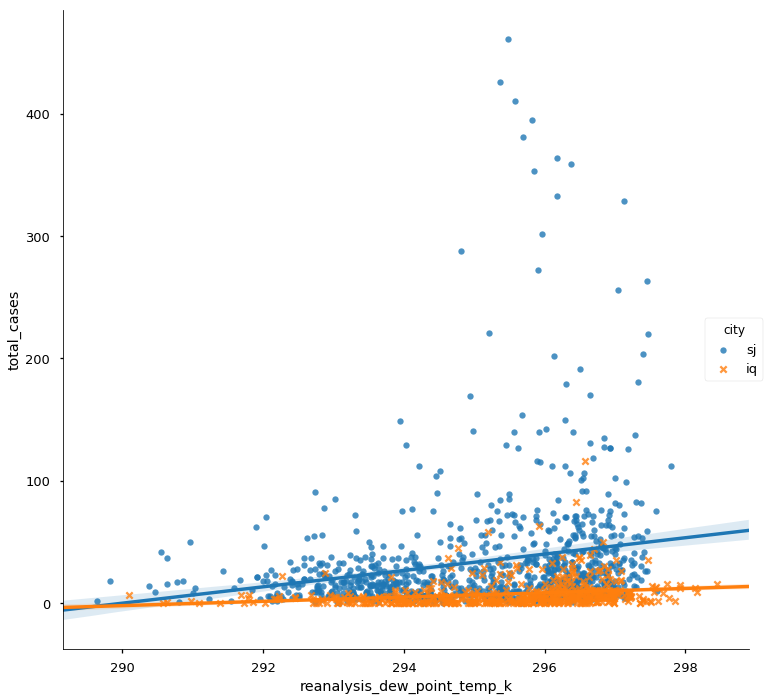

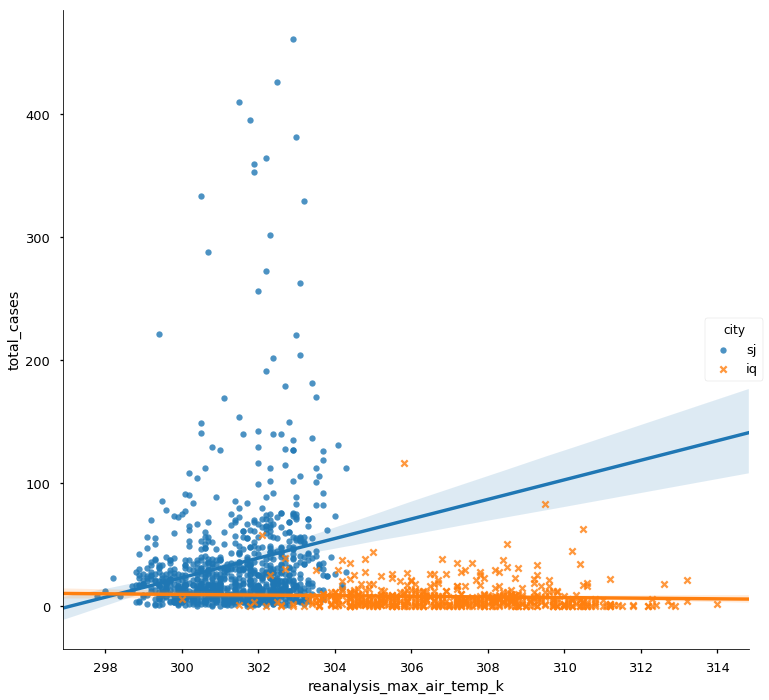

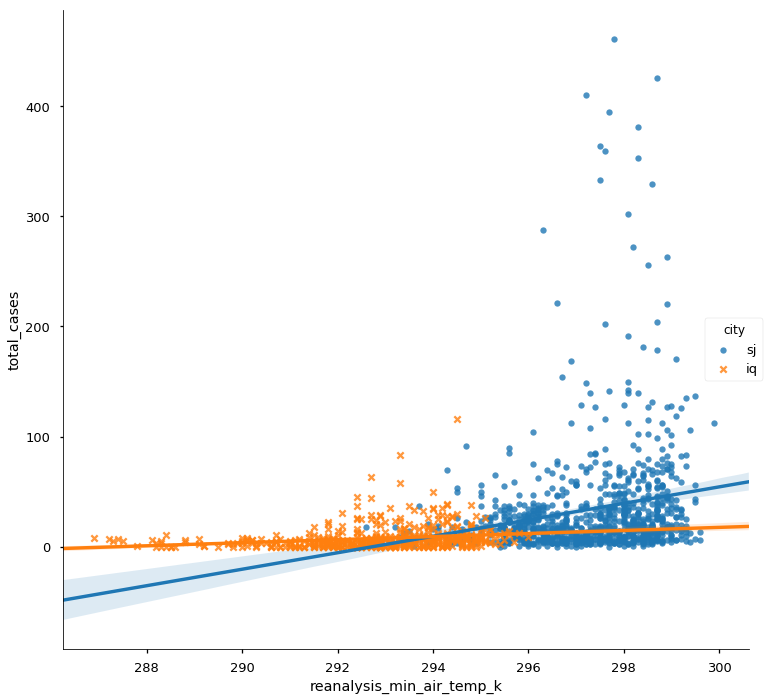

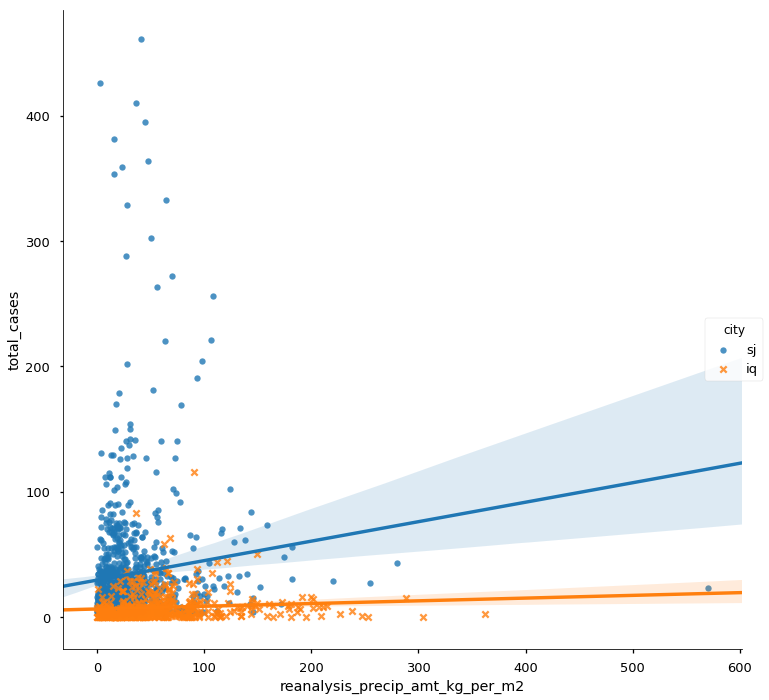

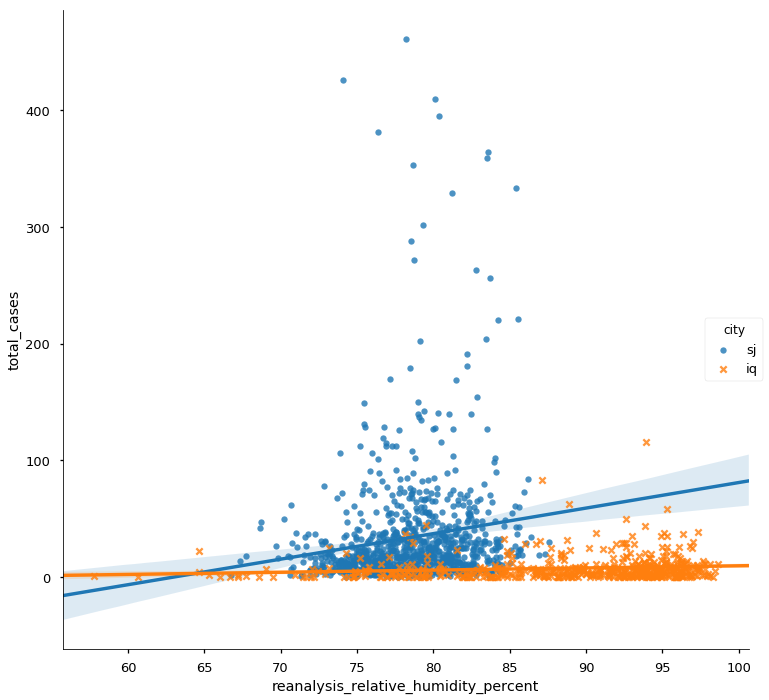

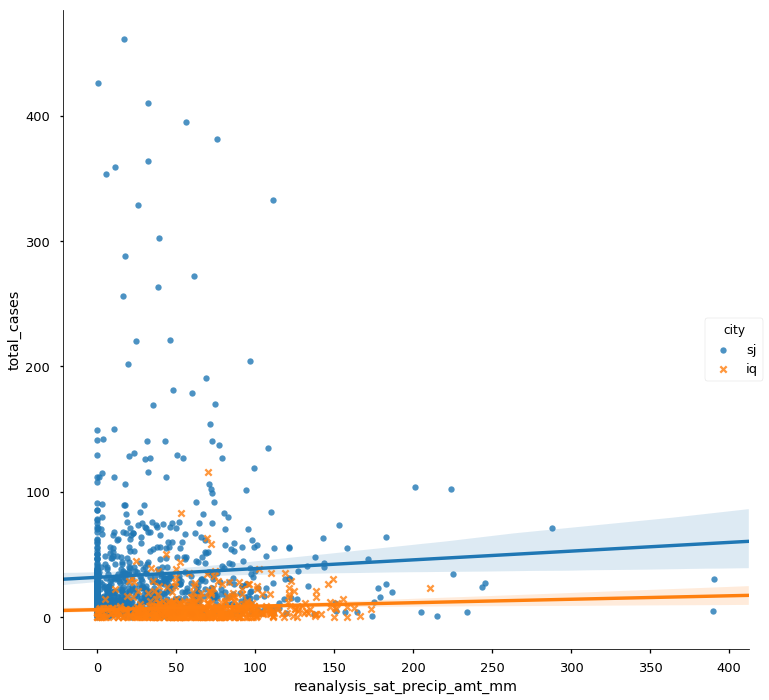

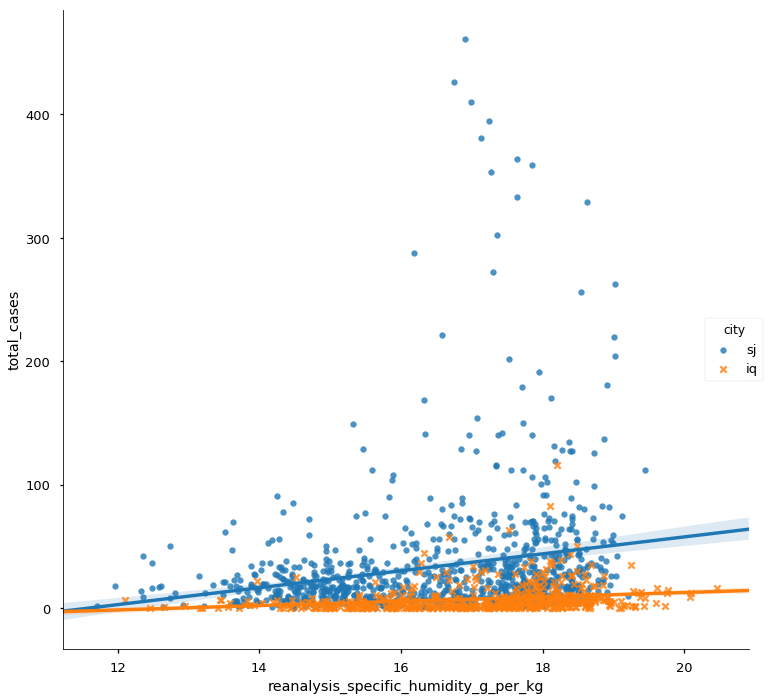

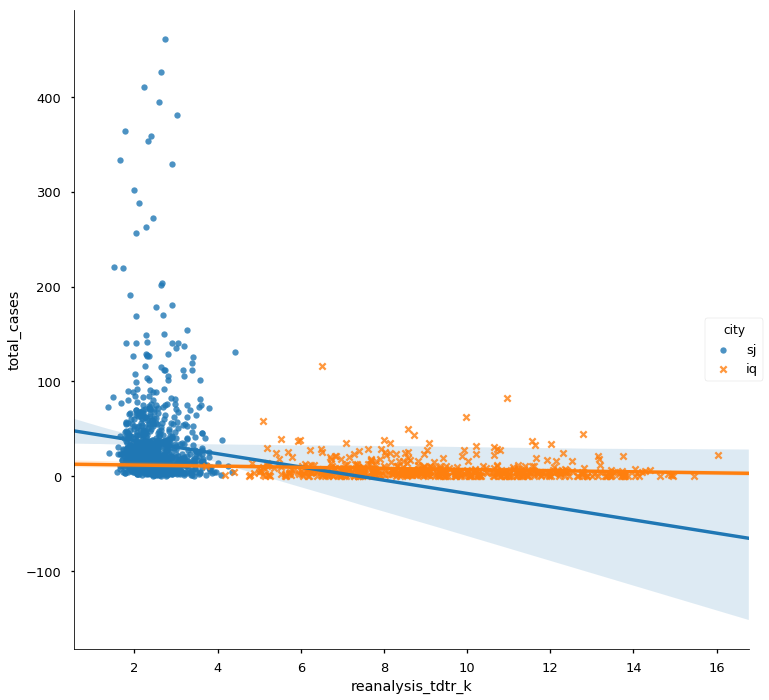

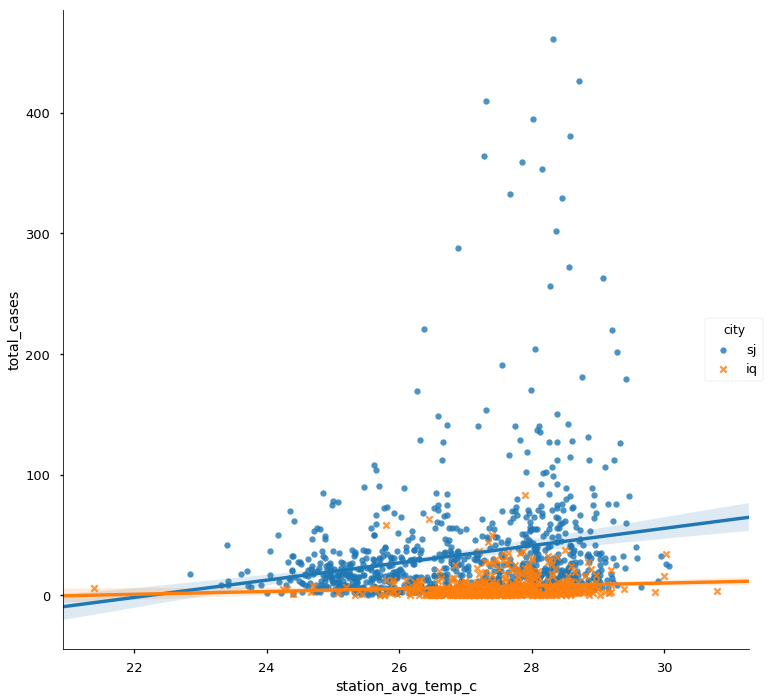

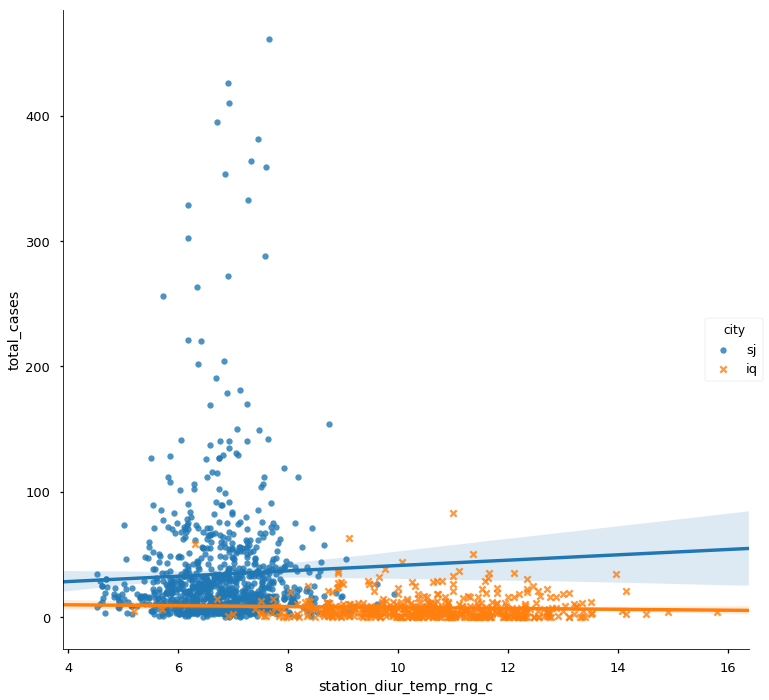

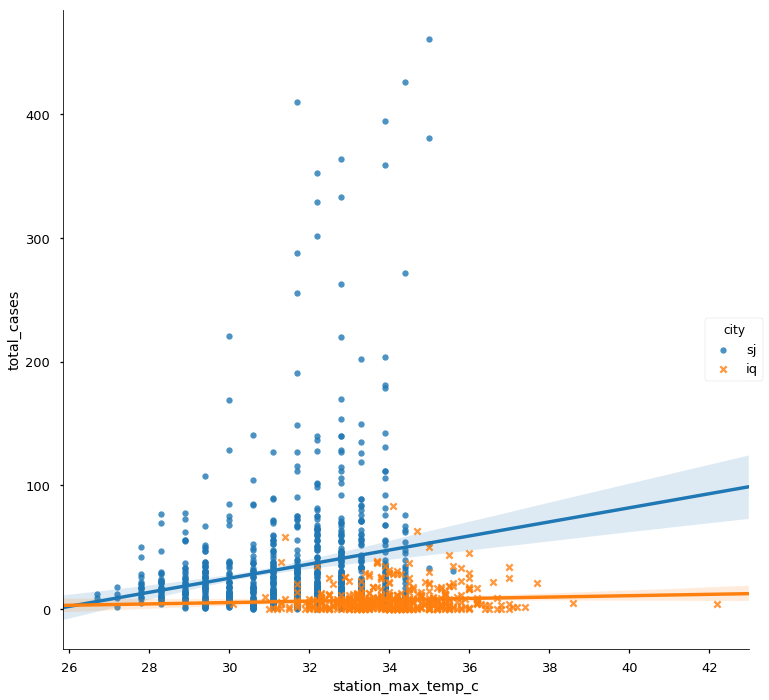

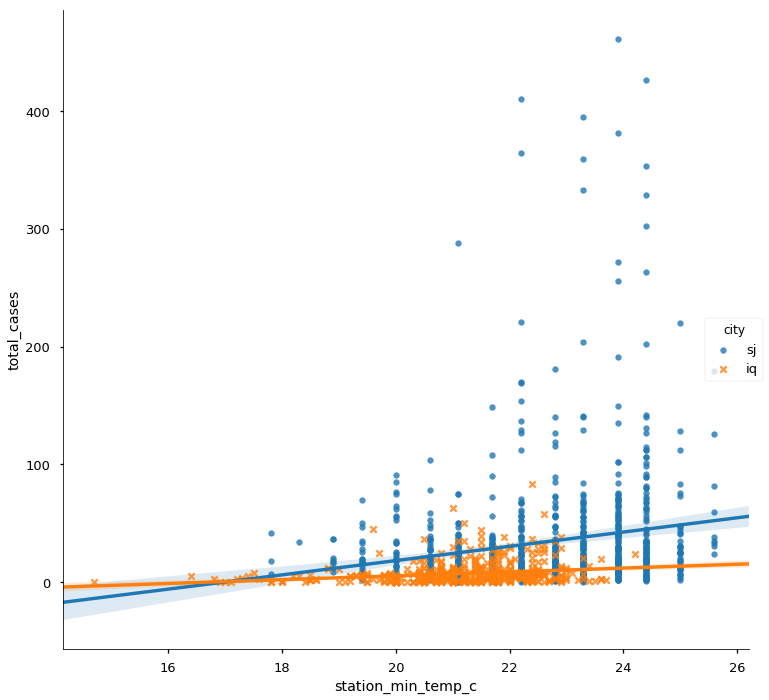

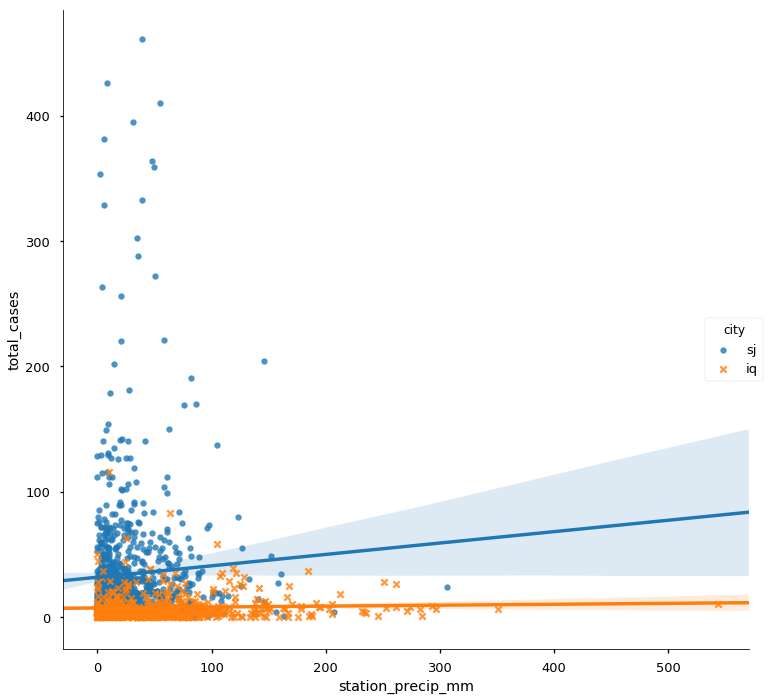

In [34]:
for i, col in enumerate(numeric_cols):
    sns.lmplot(x=col, y="total_cases", hue ='city', data=train, markers = ["o", "x"], size = 10, scatter_kws={"s": 40});
    plt.tight_layout()

# Random Forest to see strongest features. For now we drop nulls and model each city separately.

In [35]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder

# sj

In [36]:
mod = RandomForestRegressor()

Text(0.5,1,'Feature Importance for City sj')

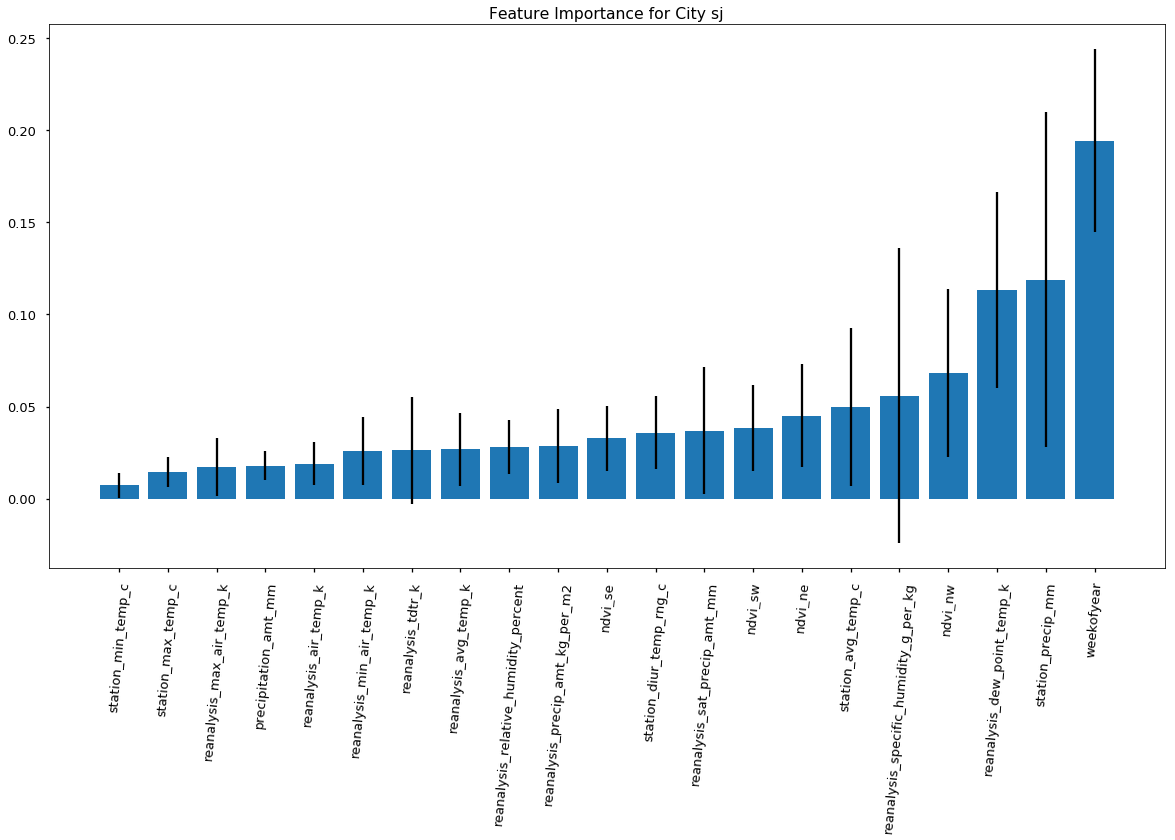

In [47]:
X = train[train['city'] == 'sj'].drop(['total_cases', 'week_start_date', 'city', 'year'], axis = 1).dropna()
y = train[train['city'] == 'sj'].dropna()['total_cases']
mod.fit(X,y)

importance = mod.feature_importances_
importance = pd.DataFrame(importance, index=X.columns, 
                          columns=["Importance"])

importance["Std"] = np.std([tree.feature_importances_
                            for tree in mod.estimators_], axis=0)

importance = importance.sort_values(by = 'Importance')

x = range(importance.shape[0])
y = importance.ix[:, 0]
yerr = importance.ix[:, 1]

fig, ax = plt.subplots(figsize = (20,10));
plt.bar(x, y, yerr=yerr, align="center");
ax.set_xticks(np.arange(21));
ax.set_xticklabels(importance.index.tolist());
plt.xticks(rotation = 85);
plt.title('Feature Importance for City sj');

In [40]:
importance.sort_values(by = 'Importance', ascending = False)

Importance       Std
reanalysis_max_air_temp_k                0.018096  0.016086
reanalysis_min_air_temp_k                0.020036  0.022798
station_max_temp_c                       0.021458  0.019528
reanalysis_air_temp_k                    0.023042  0.016775
station_min_temp_c                       0.023581  0.024581
reanalysis_tdtr_k                        0.024862  0.013904
precipitation_amt_mm                     0.028031  0.031729
reanalysis_relative_humidity_percent     0.034837  0.030218
ndvi_sw                                  0.037139  0.027103
ndvi_se                                  0.037710  0.038675
station_diur_temp_rng_c                  0.038174  0.028245
station_avg_temp_c                       0.039732  0.028029
reanalysis_avg_temp_k                    0.040599  0.058667
reanalysis_precip_amt_kg_per_m2          0.041858  0.030561
reanalysis_dew_point_temp_k              0.047014  0.045236
reanalysis_sat_precip_amt_mm             0.053174  0.049684
station_precip_mm                        0.054897  0.037050
ndvi_ne                                  0.058340  0.039740
reanalysis_specific_humidity_g_per_kg    0.069625  0.063581
ndvi_nw                                  0.085690  0.043393
weekofyear                               0.202105  0.023581

In [ ]:
importance = mod.feature_importances_
importance = pd.DataFrame(importance, index=X.columns, 
                          columns=["Importance"])

importance["Std"] = np.std([tree.feature_importances_
                            for tree in mod.estimators_], axis=0)

importance = importance.sort_values(by = 'Importance')

x = range(importance.shape[0])
y = importance.ix[:, 0]
yerr = importance.ix[:, 1]

fig, ax = plt.subplots(figsize = (20,10))
plt.bar(x, y, yerr=yerr, align="center")
ax.set_xticks(np.arange(21))
ax.set_xticklabels(importance.index.tolist())
plt.xticks(rotation = 85)

# iq

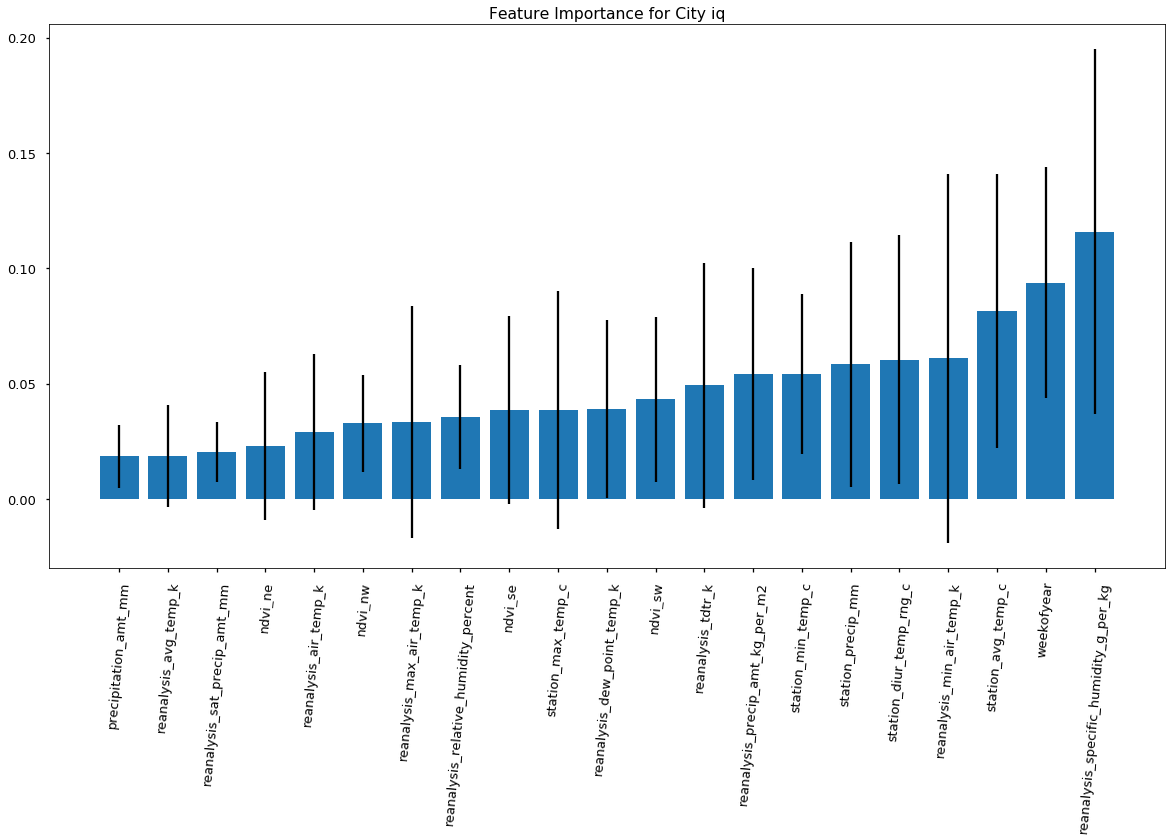

In [48]:
X = train[train['city'] == 'iq'].drop(['total_cases', 'week_start_date', 'city', 'year'], axis = 1).dropna()
y = train[train['city'] == 'iq'].dropna()['total_cases']
mod.fit(X,y)
importance = mod.feature_importances_
importance = pd.DataFrame(importance, index=X.columns, 
                          columns=["Importance"])

importance["Std"] = np.std([tree.feature_importances_
                            for tree in mod.estimators_], axis=0)

importance = importance.sort_values(by = 'Importance')

x = range(importance.shape[0])
y = importance.ix[:, 0]
yerr = importance.ix[:, 1]

fig, ax = plt.subplots(figsize = (20,10))
plt.bar(x, y, yerr=yerr, align="center")
ax.set_xticks(np.arange(21))
ax.set_xticklabels(importance.index.tolist())
plt.xticks(rotation = 85);
plt.title('Feature Importance for City iq');

In [43]:
importance.sort_values(by = 'Importance', ascending = False)

Importance       Std
reanalysis_specific_humidity_g_per_kg    0.146359  0.097777
reanalysis_min_air_temp_k                0.095656  0.118166
weekofyear                               0.087383  0.026997
ndvi_se                                  0.071200  0.050995
ndvi_sw                                  0.059580  0.037305
station_diur_temp_rng_c                  0.058849  0.048368
station_max_temp_c                       0.056407  0.038260
reanalysis_max_air_temp_k                0.048423  0.051794
station_avg_temp_c                       0.043578  0.037163
station_precip_mm                        0.037937  0.023614
reanalysis_sat_precip_amt_mm             0.037146  0.030604
ndvi_ne                                  0.035466  0.041253
reanalysis_avg_temp_k                    0.033670  0.041454
reanalysis_dew_point_temp_k              0.032293  0.036294
station_min_temp_c                       0.030772  0.024853
reanalysis_precip_amt_kg_per_m2          0.029397  0.020698
reanalysis_relative_humidity_percent     0.026990  0.027360
precipitation_amt_mm                     0.024329  0.019302
ndvi_nw                                  0.021503  0.013823
reanalysis_air_temp_k                    0.015658  0.017255
reanalysis_tdtr_k                        0.007403  0.006963